In [1]:
import os
import sys
import cv2
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

sys.path.append(str(Path.cwd().parent))
from utils.file_dialog_utils import pick_video_cv2, pick_folder

In [2]:
# --- USER CONFIGURATION ---

# Inputs
_, input_video_path = pick_video_cv2(title="Select Input Video for Wheel Geometry Setup")
templates_dir = pick_folder(title="Select Template Folder")

# Detection settings
N_SAMPLES = 10
MIN_SCORE = 0.80

# Halo settings
OUTER_INWARD_PCT = 0.10
INNER_INWARD_PCT = 0.30

# ROI settings
ROI_PADDING_PCT_X = 0.50
ROI_PADDING_PCT_Y = 0.30


In [3]:
# --- LOADING & PREPARATION ---

def load_templates_with_names(folder_path):
    """
    Loads templates and keeps their filenames.
    Returns: list of (filename, image_bgr)
    """
    paths = sorted(glob.glob(os.path.join(folder_path, "*.png")))
    template_data = []
    for p in paths:
        img = cv2.imread(p)
        if img is not None:
            filename = os.path.basename(p)
            template_data.append((filename, img))
    return template_data


def preprocess_templates_for_video(template_data):
    """
    Converts BGR templates to Grayscale ONCE to speed up video processing.
    Returns: list of (name, gray_image, width, height)
    """
    processed = []
    for name, img_bgr in template_data:
        gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
        h, w = gray.shape
        processed.append((name, gray, w, h))
    return processed

# --- TEMPLATE MATCHING LOGIC ---
def find_best_match(target_gray, gray_templates):
    """
    Optimized matcher for video. 
    Accepts PRE-CONVERTED gray templates to save time.
    """
    best_match = {
        "score": -1.0,
        "location": None,
        "width": 0,
        "height": 0,
        "name": ""
    }

    for name, tmpl_gray, w, h in gray_templates:
        res = cv2.matchTemplate(target_gray, tmpl_gray, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, max_loc = cv2.minMaxLoc(res)

        if max_val > best_match["score"]:
            best_match["score"] = max_val
            best_match["location"] = max_loc
            best_match["width"] = w
            best_match["height"] = h
            best_match["name"] = name

    return best_match

In [4]:
# --- SHAPE FITTING & VIDEO PROCESSING ---

def fit_ellipse(points_xy):
    """
    Fit an ellipse to (x,y) points using OpenCV.
    Needs >= 5 points.
    Returns: (center(x,y), axes(rx, ry), angle_deg)
    """
    pts = np.array(points_xy, dtype=np.float32).reshape(-1, 1, 2)
    (cx, cy), (MA, ma), angle = cv2.fitEllipse(pts)
    rx, ry = MA / 2.0, ma / 2.0
    return (float(cx), float(cy)), (float(rx), float(ry)), float(angle)


def distributed_frame_indices(total_frames: int, n: int):
    """
    Returns n indices spread across [0, total_frames-1].
    Ensures uniqueness and sorted order.
    """
    n = int(max(1, n))
    if total_frames <= 0:
        return [0]
    idx = np.linspace(0, max(0, total_frames-1), n, dtype=int)
    idx = np.unique(idx)
    return idx.tolist()


def process_video_sampled_frames(
    video_path: str,
    template_folder: str,
    n_samples: int = 30,
    min_score: float = 0.60,
    outer_inward_pct: float = 0.10,
    inner_inward_pct: float = 0.30,
    roi_padding_pct_x: float = 0.10,
    roi_padding_pct_y: float = 0.10,
):
    """
    Simplified pipeline:
      1) Sample N distributed frames from the video
      2) Template-match on ONLY those frames
      3) Collect accepted center points
      4) Fit ellipse (>=5 points) else circle fallback
      5) Overlay the fitted shape on the FIRST frame

    Params:
      - n_samples: how many distributed frames to evaluate (higher = better fit, slower)
      - min_score: NCC threshold
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Could not open video: {video_path}")

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Grab the first frame for overlay output
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    ok, first_frame = cap.read()
    if not ok:
        cap.release()
        raise RuntimeError("Could not read first frame.")

    # Load templates
    templates_with_names = load_templates_with_names(template_folder)
    gray_templates = preprocess_templates_for_video(templates_with_names)

    sample_idxs = distributed_frame_indices(total_frames, n_samples)
    print(f"Total frames: {total_frames} | sampling {len(sample_idxs)} frames")

    rows = []

    for idx in sample_idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
        ok, frame = cap.read()
        if not ok:
            continue

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        match = find_best_match(gray, gray_templates)

        if match.get("location") is None:
            continue

        score = float(match["score"])
        if score < min_score:
            continue

        # center coordinate
        tlx, tly = match["location"]
        w, h = match["width"], match["height"]
        cx = tlx + w / 2.0
        cy = tly + h / 2.0

        rows.append({
            "frame_idx": int(idx),
            "center_x": float(cx),
            "center_y": float(cy),
            "score": score,
            "template": match.get("name", "")
        })

    cap.release()

    print(f"Accepted points: {len(rows)}")
    if not rows:
        print("No points accepted. Try lowering min_score or increasing n_samples.")
        return
    
    points_xy = [(r["center_x"], r["center_y"]) for r in rows]

    # Fit ellipse if possible, else circle fallback
    overlay = first_frame.copy()

    if len(points_xy) >= 5:
        (cx, cy), (rx, ry), angle = fit_ellipse(points_xy)
        cv2.ellipse(
            overlay,
            (int(cx), int(cy)),
            (int(rx), int(ry)),
            angle,
            0, 360,
            (0, 0, 255),
            3
        )
        cv2.circle(overlay, (int(cx), int(cy)), 4, (0, 255, 0), -1)

        print(f"\nEllipse -> center=({cx:.1f},{cy:.1f}), axes=({rx:.1f},{ry:.1f}), angle={angle:.1f}°")

        # --- define zero reference angle using FIRST frame (stable reference) ---
        first_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
        zero_match = find_best_match(first_gray, gray_templates)

        if zero_match.get("location") is None:
            raise RuntimeError("Could not find zero template on first frame; cannot compute zero reference angle.")

        tlx, tly = zero_match["location"]
        w, h = zero_match["width"], zero_match["height"]
        zero_x = tlx + w / 2.0
        zero_y = tly + h / 2.0

        print(f"Zero reference on first frame -> (x,y)=({zero_x:.1f},{zero_y:.1f}) score={zero_match['score']:.3f}")

        # --- ROI rectangle around wheel (ellipse bounds + independent x/y padding) ---
        frame_h, frame_w = first_frame.shape[:2]
        pad_x = rx * float(roi_padding_pct_x)
        pad_y = ry * float(roi_padding_pct_y)

        roi_x1 = int(max(0, np.floor(cx - rx - pad_x)))
        roi_y1 = int(max(0, np.floor(cy - ry - pad_y)))
        roi_x2 = int(min(frame_w - 1, np.ceil(cx + rx + pad_x)))
        roi_y2 = int(min(frame_h - 1, np.ceil(cy + ry + pad_y)))

        roi_w = int(max(0, roi_x2 - roi_x1))
        roi_h = int(max(0, roi_y2 - roi_y1))

        print(
            f"ROI -> x1={roi_x1}, y1={roi_y1}, x2={roi_x2}, y2={roi_y2}, "
            f"w={roi_w}, h={roi_h}, padding_x={roi_padding_pct_x:.3f}, padding_y={roi_padding_pct_y:.3f}"
        )

        # export geometry handoff artifact
        geometry = {
            "ellipse": {
                "cx": float(cx),
                "cy": float(cy),
                "rx": float(rx),
                "ry": float(ry),
                "rotation_deg": float(angle),
            },
            "halo": {
                "outer_inward_pct": float(outer_inward_pct), 
                "inner_inward_pct": float(inner_inward_pct)
            },
            "roi": {
                "x1": int(roi_x1),
                "y1": int(roi_y1),
                "x2": int(roi_x2),
                "y2": int(roi_y2),
                "width": int(roi_w),
                "height": int(roi_h),
                "padding_pct_x": float(roi_padding_pct_x),
                "padding_pct_y": float(roi_padding_pct_y)
            },
            "wheel": {
                "type": "EU",
                "pockets": 37
            }
        }

        with open("wheel_geometry.json", "w") as f:
            json.dump(geometry, f, indent=2)

        print("\nSaved wheel_geometry.json")

In [5]:
#--- DEBUG VISUALIZATION ---

def debug_draw_ellipse_from_geometry(
    video_path: str, 
    geometry_path: str, 
    frame_index: int = 0
):
    """
    Visual sanity check:
    - Draw fitted ellipse
    - Draw center point
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Failed to open video: {video_path}")

    # seek to frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
    ok, frame = cap.read()
    cap.release()
    if not ok:
        raise RuntimeError(f"Failed to read frame {frame_index}")

    with open(geometry_path, "r") as f:
        geom = json.load(f)

    cx = geom["ellipse"]["cx"]
    cy = geom["ellipse"]["cy"]
    rx = geom["ellipse"]["rx"]
    ry = geom["ellipse"]["ry"]
    rot = geom["ellipse"]["rotation_deg"]

    overlay = frame.copy()

    # draw fitted ellipse
    cv2.ellipse(
        overlay,
        (int(cx), int(cy)),
        (int(rx), int(ry)),
        rot,
        0, 360,
        (0, 255, 0),
        2
    )

    # draw center
    cv2.circle(overlay, (int(cx), int(cy)), 4, (0, 255, 0), -1)

    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Ellipse Sanity Check")
    plt.show()

    
def debug_draw_halo_from_geometry(
    video_path: str,
    geometry_path: str,
    frame_index: int = 0,
    show_filled_band: bool = True,
    band_alpha: float = 0.35
):
    """
    Visual sanity check:
    - Draw fitted ellipse
    - Draw halo outer+inner boundary ellipses (computed from inward %)
    - Optionally render the halo band as a filled mask overlay
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Failed to open video: {video_path}")

    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
    ok, frame = cap.read()
    cap.release()
    if not ok:
        raise RuntimeError(f"Failed to read frame {frame_index}")

    with open(geometry_path, "r") as f:
        geom = json.load(f)

    cx = float(geom["ellipse"]["cx"])
    cy = float(geom["ellipse"]["cy"])
    rx = float(geom["ellipse"]["rx"])
    ry = float(geom["ellipse"]["ry"])
    rot = float(geom["ellipse"]["rotation_deg"])

    outer_inward = float(geom["halo"]["outer_inward_pct"])
    inner_inward = float(geom["halo"]["inner_inward_pct"])

    # Halo boundaries are "shrunk" versions of the fitted ellipse
    # outer boundary = slightly inside outer rim
    # inner boundary = further inside
    outer_rx = rx * (1.0 - outer_inward)
    outer_ry = ry * (1.0 - outer_inward)

    inner_rx = rx * (1.0 - inner_inward)
    inner_ry = ry * (1.0 - inner_inward)

    overlay = frame.copy()

    # Draw fitted ellipse (baseline)
    cv2.ellipse(overlay, (int(cx), int(cy)), (int(rx), int(ry)), rot, 0, 360, (0, 255, 0), 2)

    # Draw halo boundaries
    cv2.ellipse(overlay, (int(cx), int(cy)), (int(outer_rx), int(outer_ry)), rot, 0, 360, (255, 255, 0), 2)  # outer halo line
    cv2.ellipse(overlay, (int(cx), int(cy)), (int(inner_rx), int(inner_ry)), rot, 0, 360, (0, 255, 255), 2)  # inner halo line

    # Optional: filled band mask for the halo region
    if show_filled_band:
        mask_outer = np.zeros(frame.shape[:2], dtype=np.uint8)
        mask_inner = np.zeros(frame.shape[:2], dtype=np.uint8)

        cv2.ellipse(mask_outer, (int(cx), int(cy)), (int(outer_rx), int(outer_ry)), rot, 0, 360, 255, -1)
        cv2.ellipse(mask_inner, (int(cx), int(cy)), (int(inner_rx), int(inner_ry)), rot, 0, 360, 255, -1)

        band_mask = cv2.subtract(mask_outer, mask_inner)

        # Paint the band on a colored layer (red-ish) then alpha blend
        color_layer = np.zeros_like(frame, dtype=np.uint8)
        color_layer[band_mask > 0] = (0, 0, 255)

        overlay = cv2.addWeighted(overlay, 1.0, color_layer, band_alpha, 0)

    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Halo Sanity Check (outer/inner boundaries + optional band)")
    plt.show()


def debug_draw_roi_from_geometry(
    video_path: str,
    geometry_path: str,
    frame_index: int = 0
):
    """
    Visual sanity check:
    - Draw ROI rectangle saved in geometry JSON
    - Draw ellipse center for reference (if available)
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Failed to open video: {video_path}")

    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
    ok, frame = cap.read()
    cap.release()
    if not ok:
        raise RuntimeError(f"Failed to read frame {frame_index}")

    with open(geometry_path, "r") as f:
        geom = json.load(f)

    if "roi" not in geom:
        raise RuntimeError("ROI not found in geometry JSON.")

    x1 = int(geom["roi"]["x1"])
    y1 = int(geom["roi"]["y1"])
    x2 = int(geom["roi"]["x2"])
    y2 = int(geom["roi"]["y2"])

    overlay = frame.copy()

    # Draw ROI rectangle
    cv2.rectangle(overlay, (x1, y1), (x2, y2), (255, 0, 255), 2)

    # Optional center marker from ellipse
    if "ellipse" in geom and "cx" in geom["ellipse"] and "cy" in geom["ellipse"]:
        cx = int(geom["ellipse"]["cx"])
        cy = int(geom["ellipse"]["cy"])
        cv2.circle(overlay, (cx, cy), 4, (0, 255, 0), -1)

    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("ROI Sanity Check")
    plt.show()

Total frames: 207 | sampling 10 frames
Accepted points: 10

Ellipse -> center=(663.1,344.9), axes=(223.9,237.8), angle=93.8°
Zero reference on first frame -> (x,y)=(645.5,121.5) score=0.920
ROI -> x1=327, y1=35, x2=1000, y2=655, w=673, h=620, padding_x=0.500, padding_y=0.300

Saved wheel_geometry.json


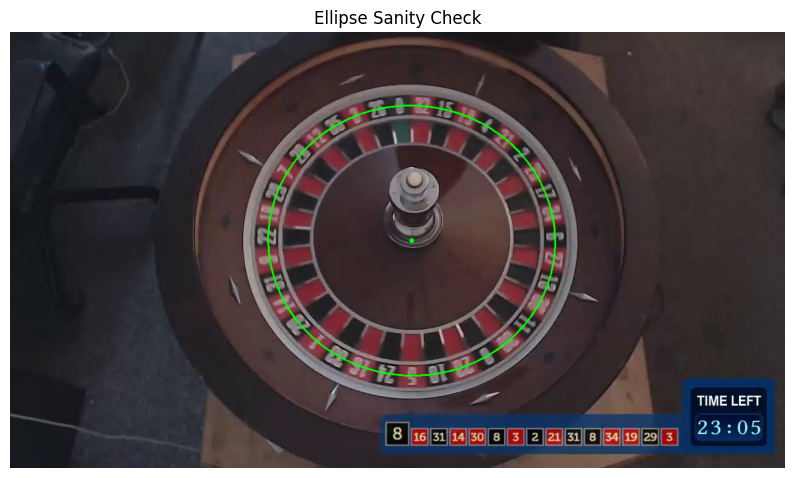

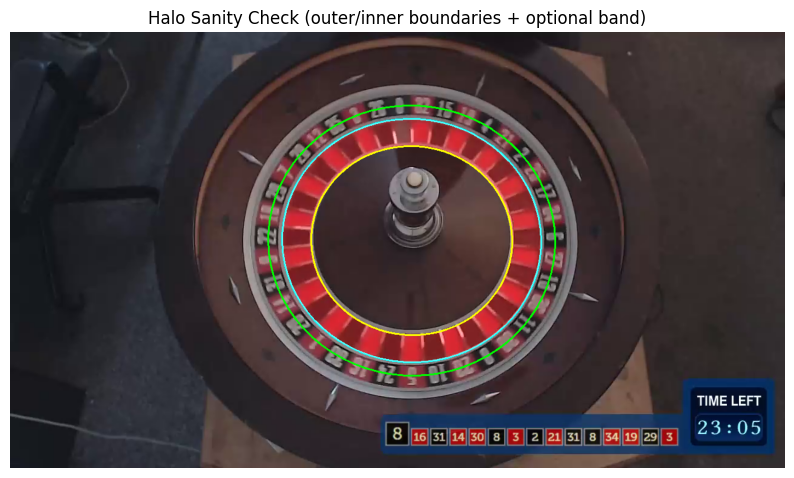

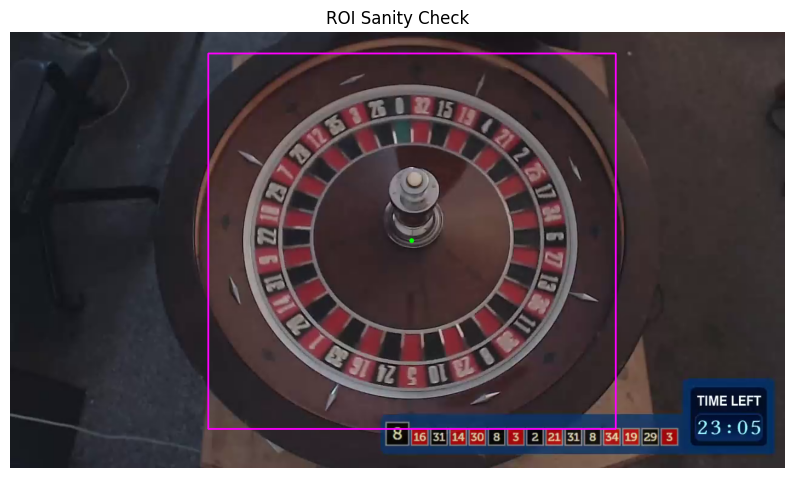

In [6]:
# --- MAIN EXECUTION ---

process_video_sampled_frames(
    video_path=input_video_path,
    template_folder=templates_dir,
    n_samples=N_SAMPLES,
    min_score=MIN_SCORE,
    outer_inward_pct=OUTER_INWARD_PCT,
    inner_inward_pct=INNER_INWARD_PCT,
    roi_padding_pct_x=ROI_PADDING_PCT_X,
    roi_padding_pct_y=ROI_PADDING_PCT_Y
)

debug_draw_ellipse_from_geometry(input_video_path, "wheel_geometry.json", frame_index=0)
debug_draw_halo_from_geometry(input_video_path, "wheel_geometry.json", frame_index=0, show_filled_band=True)
debug_draw_roi_from_geometry(input_video_path, "wheel_geometry.json", frame_index=0)